# Timeseries forecasting for weather prediction

**Authors:** [Prabhanshu Attri](https://prabhanshu.com/github), [Yashika Sharma](https://github.com/yashika51), [Kristi Takach](https://github.com/ktakattack), [Falak Shah](https://github.com/falaktheoptimist)<br>
**Date created:** 2020/06/23<br>
**Last modified:** 2022/03/27 by B. Poczos<br>
**Description:** This notebook demonstrates how to do timeseries forecasting using a LSTM model.
**Source:** https://keras.io/examples/timeseries/timeseries_weather_forecasting/

## Setup
This example requires TensorFlow 2.3 or higher.

In [1]:
!nvidia-smi

Sun Mar 27 22:35:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

## Climate Data Time-Series

We will be using Jena Climate dataset recorded by the
[Max Planck Institute for Biogeochemistry](https://www.bgc-jena.mpg.de/wetter/).
The dataset consists of **14 features such as temperature, pressure, humidity etc, recorded once per
10 minutes**.

**Location**: Weather Station, Max Planck Institute for Biogeochemistry
in Jena, Germany

**Time-frame Considered**: Jan 10, 2009 - December 31, 2016


The table below shows the column names, their value formats, and their description.

Index| Features      |Format             |Description
-----|---------------|-------------------|-----------------------
1    |Date Time      |01.01.2009 00:10:00|Date-time reference
2    |p (mbar)       |996.52             |The pascal SI derived unit of pressure used to quantify internal pressure. Meteorological reports typically state atmospheric pressure in millibars.
3    |T (degC)       |-8.02              |Temperature in Celsius
4    |Tpot (K)       |265.4              |Temperature in Kelvin
5    |Tdew (degC)    |-8.9               |Temperature in Celsius relative to humidity. Dew Point is a measure of the absolute amount of water in the air, the DP is the temperature at which the air cannot hold all the moisture in it and water condenses.
6    |rh (%)         |93.3               |Relative Humidity is a measure of how saturated the air is with water vapor, the %RH determines the amount of water contained within collection objects.
7    |VPmax (mbar)   |3.33               |Saturation vapor pressure
8    |VPact (mbar)   |3.11               |Vapor pressure
9    |VPdef (mbar)   |0.22               |Vapor pressure deficit
10   |sh (g/kg)      |1.94               |Specific humidity
11   |H2OC (mmol/mol)|3.12               |Water vapor concentration
12   |rho (g/m ** 3) |1307.75            |Airtight
13   |wv (m/s)       |1.03               |Wind speed
14   |max. wv (m/s)  |1.75               |Maximum wind speed
15   |wd (deg)       |152.3              |Wind direction in degrees

## Load the data

In [3]:
from zipfile import ZipFile
import os

uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

df = pd.read_csv(csv_path)

In [4]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


## Raw Data Visualization

To give us a sense of the data we are working with, each feature has been plotted below.
This shows the distinct pattern of each feature over the time period from **2009 to 2016**.
It also shows where anomalies are present, which will be addressed during normalization.

In [5]:
titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

date_time_key = "Date Time"

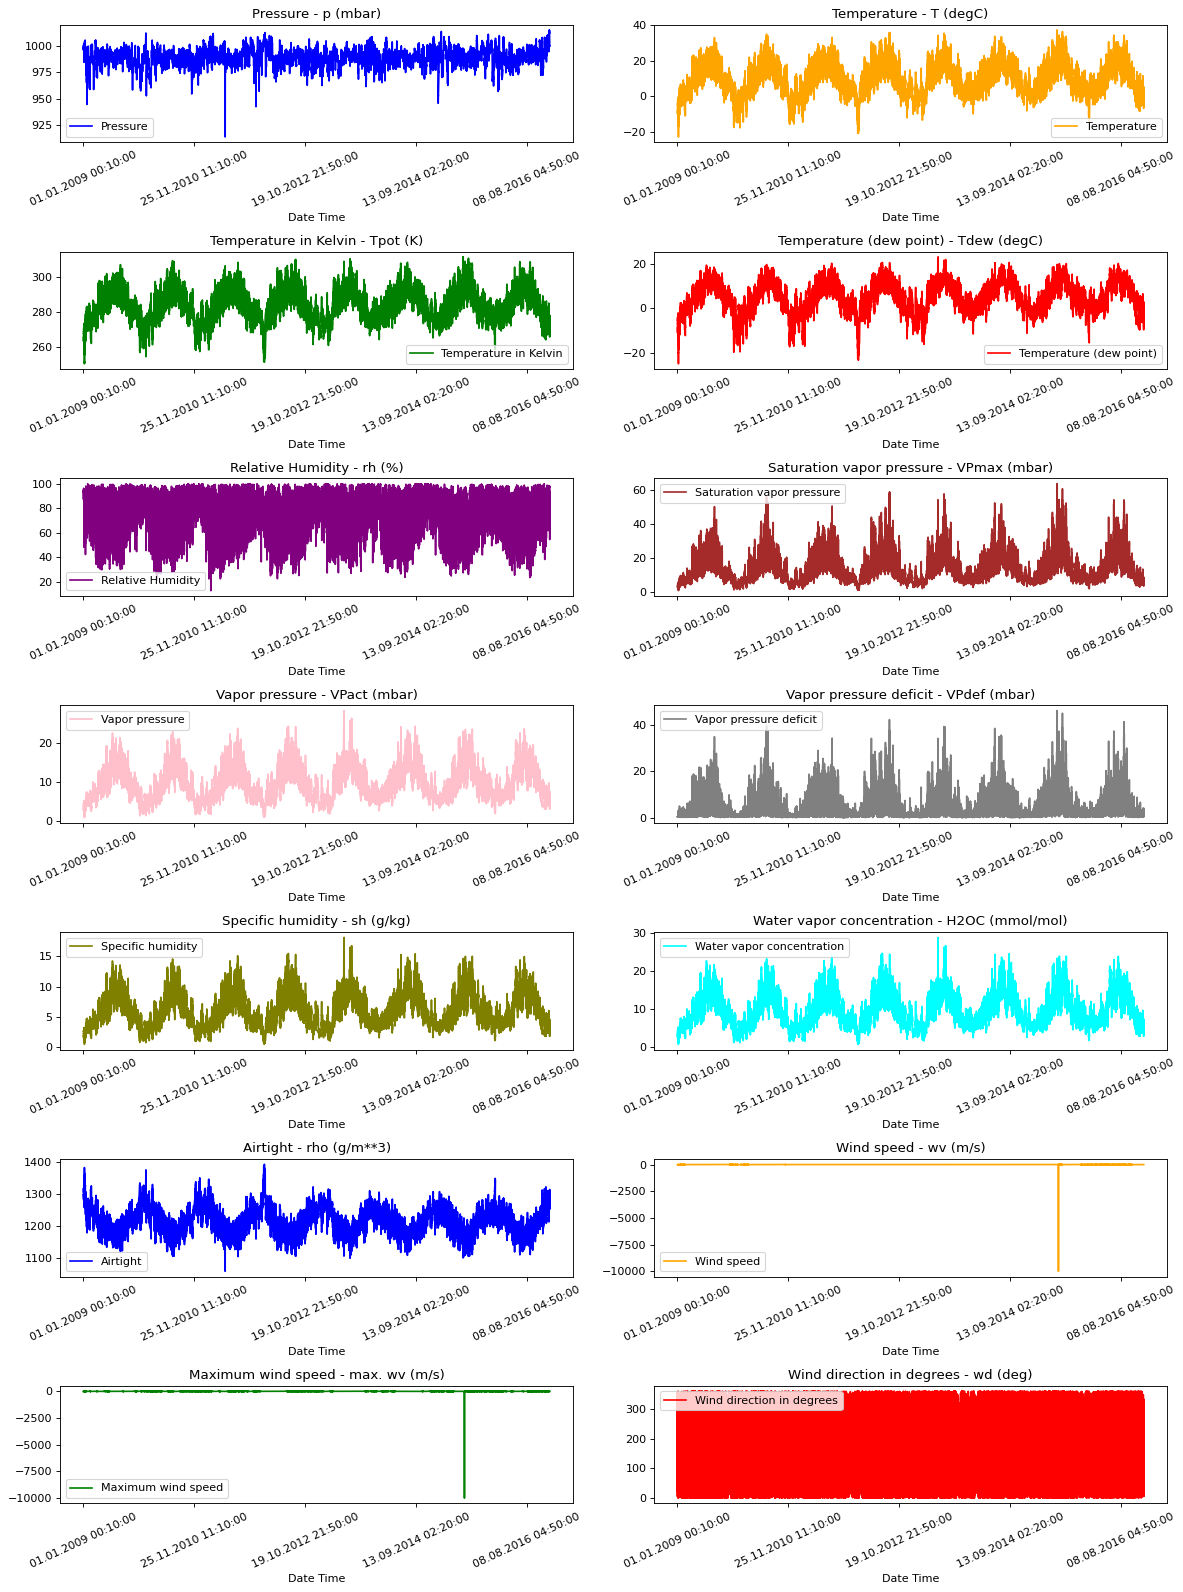

In [6]:
def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()


show_raw_visualization(df)

### Correlations between features

This heat map shows the correlation between different features.

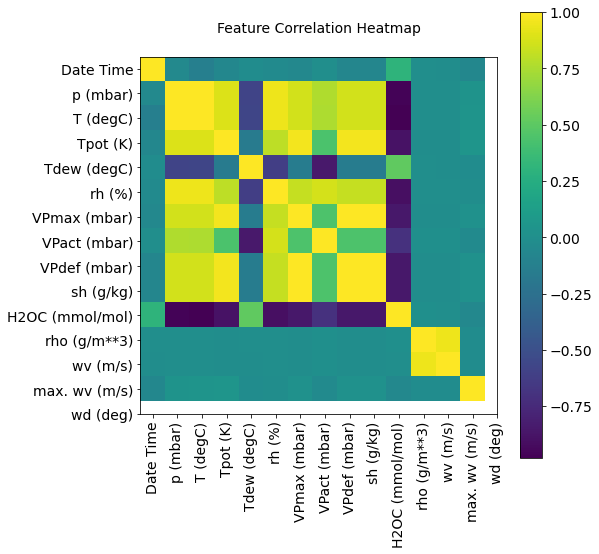

In [7]:
def show_heatmap(data):
    plt.rcParams["figure.figsize"] = (8,8)
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()


show_heatmap(df)


## Data Preprocessing

Here we are picking **~300,000 data points for training**. Observation is recorded every
10 mins, that means **6 times per hour**. We will **resample one point per hour** since no
drastic change is expected within 60 minutes. We do this via the `sampling_rate`
argument in `timeseries_dataset_from_array` utility.

We are tracking data from **past 720 timestamps (720/6=120 hours)**. This data will be
used to **predict the temperature after 72 timestamps (72/6=12 hours)**.

Since every feature has values with
varying ranges, we do normalization to confine feature values to a range of `[0, 1]` before
training a neural network.
We do this by **subtracting the mean and dividing by the standard deviation of each feature**.

71.5 % of the data will be used to train the model, i.e. 300,693 rows. `split_fraction` can
be changed to alter this percentage.

**Input**: The model is shown data for first 5 days i.e. 720=120\*6 observations, that are subsampled every
hour. **The length of the model's input is 120**.

**Target**: The temperature after 72 (12 hours \* 6 observation per hour) observation will be
used as a label.

In [8]:
split_fraction = 0.715
train_split = int(split_fraction * int(df.shape[0]))
print(f'train_split: {train_split}')
step = 6

past = 720
future = 72
learning_rate = 0.001
batch_size = 256
epochs = 10


def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std


train_split: 300693


We can see from the correlation heatmap, few parameters like Relative Humidity and
Specific Humidity are redundant. Hence we will be using selected features only for the prediction.

In [9]:
print(
    "The selected parameters are:",
    ", ".join([titles[i] for i in [0, 1, 5, 7, 8, 10, 11]]),
)
selected_features = [feature_keys[i] for i in [0, 1, 5, 7, 8, 10, 11]]


The selected parameters are: Pressure, Temperature, Saturation vapor pressure, Vapor pressure deficit, Specific humidity, Airtight, Wind speed


In [10]:
features = df[selected_features]
features.index = df[date_time_key]
features.head()


,p (mbar),T (degC),VPmax (mbar),VPdef (mbar),sh (g/kg),rho (g/m**3),wv (m/s)
Date Time,,,,,,,
01.01.2009 00:10:00,996.52,-8.02,3.33,0.22,1.94,1307.75,1.03
01.01.2009 00:20:00,996.57,-8.41,3.23,0.21,1.89,1309.80,0.72
01.01.2009 00:30:00,996.53,-8.51,3.21,0.20,1.88,1310.24,0.19
01.01.2009 00:40:00,996.51,-8.31,3.26,0.19,1.92,1309.19,0.34
01.01.2009 00:50:00,996.51,-8.27,3.27,0.19,1.92,1309.00,0.32


In [11]:
features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()


,0,1,2,3,4,5,6
0,0.955451,-2.000020,-1.319782,-0.788479,-1.500927,2.237658,-0.732997
1,0.961528,-2.045185,-1.332806,-0.790561,-1.519521,2.287838,-0.936002
2,0.956666,-2.056766,-1.335410,-0.792642,-1.523239,2.298608,-1.283076
3,0.954236,-2.033604,-1.328898,-0.794724,-1.508364,2.272906,-1.184847
4,0.954236,-2.028972,-1.327596,-0.794724,-1.508364,2.268256,-1.197944


In [12]:

train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]

In [13]:
print(train_data.shape)
print(val_data.shape)

(300693, 7)
(119858, 7)


# Training dataset

The training dataset labels starts from the 792nd observation (720 + 72).

In [14]:
print(past)
print(future)
print(train_split)

720
72
300693


In [15]:
start = past + future
end = start + train_split
print(f'start: {start}')
print(f'end: {end}')

start: 792
end: 301485


In [16]:
print(train_data.shape)
print(features.shape)
features.head()

(300693, 7)
(420551, 7)


,0,1,2,3,4,5,6
0,0.955451,-2.000020,-1.319782,-0.788479,-1.500927,2.237658,-0.732997
1,0.961528,-2.045185,-1.332806,-0.790561,-1.519521,2.287838,-0.936002
2,0.956666,-2.056766,-1.335410,-0.792642,-1.523239,2.298608,-1.283076
3,0.954236,-2.033604,-1.328898,-0.794724,-1.508364,2.272906,-1.184847
4,0.954236,-2.028972,-1.327596,-0.794724,-1.508364,2.268256,-1.197944


In [17]:
x_train = train_data[[i for i in range(7)]].values #The training data with 7 input features
y_train = features.iloc[start:end][[1]] #Select the tempreature feature for target

print(x_train.shape)
print(y_train.shape)

(300693, 7)
(300693, 1)


In [18]:
sequence_length = int(past / step)
print(sequence_length)

120


The `timeseries_dataset_from_array` function takes in a sequence of data-points gathered at
equal intervals, along with time series parameters such as length of the
sequences/windows, spacing between two sequence/windows, etc., to produce batches of
sub-timeseries inputs and targets sampled from the main timeseries.

In [19]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

In [20]:
print(batch_size)
print(step)
print(sequence_length)

256
6
120


**Show some examples from the training set**

In [21]:
# Each batch has 256 instances
# Each training input instance time series has length 120 and 7 features
# Each target instance has length 1 (Temperature after 72 time points)
for batch in dataset_train.take(5):
    inputs, targets = batch
    print("Input shape:", inputs.numpy().shape)
    print("Target shape:", targets.numpy().shape)


Input shape: (256, 120, 7)
Target shape: (256, 1)
Input shape: (256, 120, 7)
Target shape: (256, 1)
Input shape: (256, 120, 7)
Target shape: (256, 1)
Input shape: (256, 120, 7)
Target shape: (256, 1)
Input shape: (256, 120, 7)
Target shape: (256, 1)


## Validation dataset

The validation dataset must not contain the last 792 rows as we won't have label data for
those records, hence 792 must be subtracted from the end of the data.

The validation label dataset must start from 792 after train_split, hence we must add
past + future (792) to label_start.

In [22]:
x_end = len(val_data) - past - future
print(f'x_end: {x_end}')
label_start = train_split + past + future
print(f'label_start: {label_start}')


x_end: 119066
label_start: 301485


In [23]:
x_val = val_data.iloc[:x_end][[i for i in range(7)]].values
y_val = features.iloc[label_start:][[1]]
print(x_val.shape)
print(y_val.shape)

(119066, 7)
(119066, 1)


In [24]:

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

**show some examples from the validation set**

In [25]:
# Each batch has 256 instances
# Each training input instance time series has length 120 and 7 features
# Each target instance has length 1 (Temperature after 72 time points)
for batch in dataset_val.take(5):
    inputs, targets = batch
    print("Input shape:", inputs.numpy().shape)
    print("Target shape:", targets.numpy().shape)


Input shape: (256, 120, 7)
Target shape: (256, 1)
Input shape: (256, 120, 7)
Target shape: (256, 1)
Input shape: (256, 120, 7)
Target shape: (256, 1)
Input shape: (256, 120, 7)
Target shape: (256, 1)
Input shape: (256, 120, 7)
Target shape: (256, 1)


## Creating a model with an LSTM layer

In [26]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 7)]          0         
                                                                 
 lstm (LSTM)                 (None, 32)                5120      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 5,153
Trainable params: 5,153
Non-trainable params: 0
_________________________________________________________________


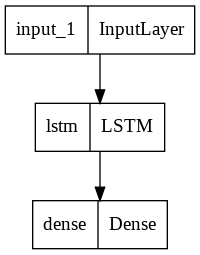

In [27]:
keras.utils.plot_model(model)

We'll use the `ModelCheckpoint` callback to regularly save checkpoints, and
the `EarlyStopping` callback to interrupt training when the validation loss
is not longer improving.

In [28]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)



## Training

**The cell below will take about 10 minutes to complete**

In [29]:
history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/10
1171/1172 [============================>.] - ETA: 0s - loss: 0.2067
Epoch 1: val_loss improved from inf to 0.15886, saving model to model_checkpoint.h5
1172/1172 [==============================] - 66s 55ms/step - loss: 0.2066 - val_loss: 0.1589
Epoch 2/10
1172/1172 [==============================] - ETA: 0s - loss: 0.1287
Epoch 2: val_loss improved from 0.15886 to 0.14748, saving model to model_checkpoint.h5
1172/1172 [==============================] - 57s 48ms/step - loss: 0.1287 - val_loss: 0.1475
Epoch 3/10
1171/1172 [============================>.] - ETA: 0s - loss: 0.1161
Epoch 3: val_loss did not improve from 0.14748
1172/1172 [==============================] - 57s 49ms/step - loss: 0.1160 - val_loss: 0.1585
Epoch 4/10
1172/1172 [==============================] - ETA: 0s - loss: 0.1115
Epoch 4: val_loss did not improve from 0.14748
1172/1172 [==============================] - 56s 48ms/step - loss: 0.1115 - val_loss: 0.1572
Epoch 5/10
1172/1172 [========================

We can visualize the loss with the function below. After one point, the loss stops
decreasing.

### Visualize the loss during training

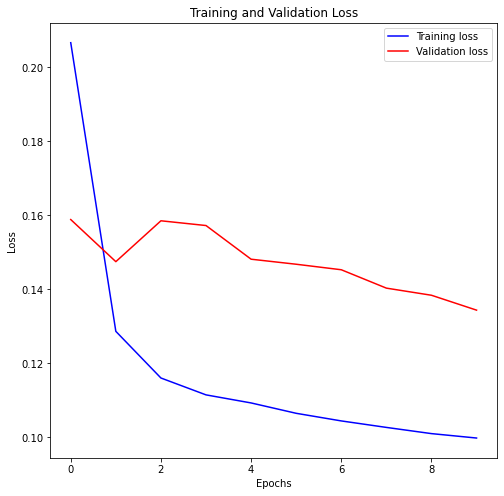

In [30]:

def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

## Prediction

The trained model above is now able to make predictions for values from
validation set.

In [31]:
#This will plot the time series input, the y target, and the prediction
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


(120, 7)
(1,)


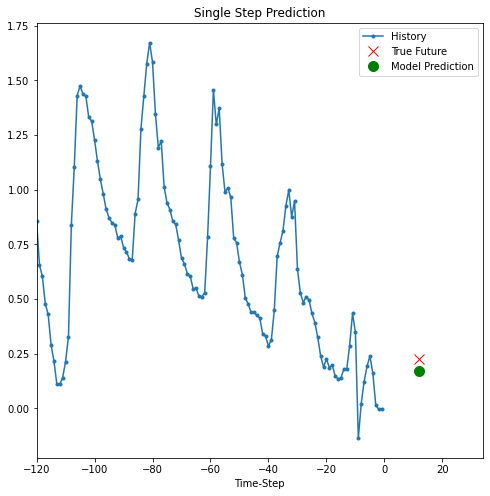

(120, 7)
(1,)


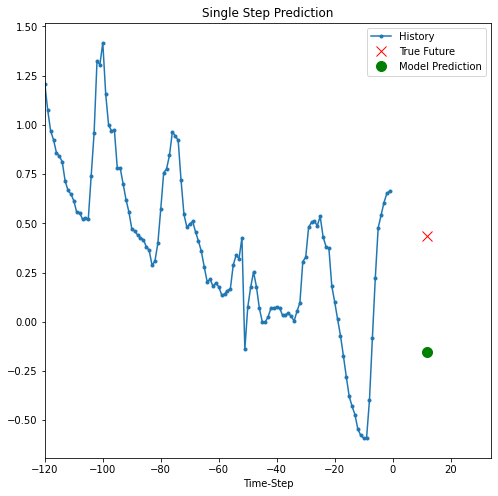

(120, 7)
(1,)


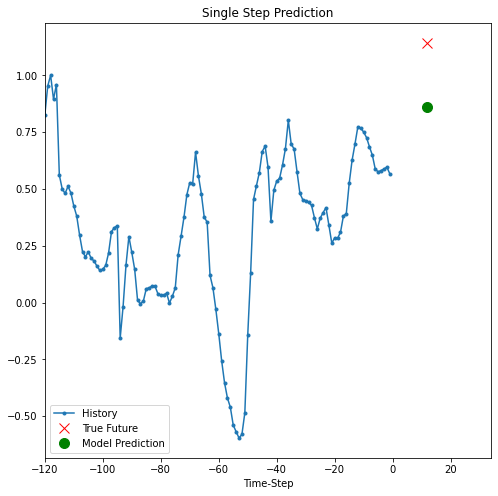

(120, 7)
(1,)


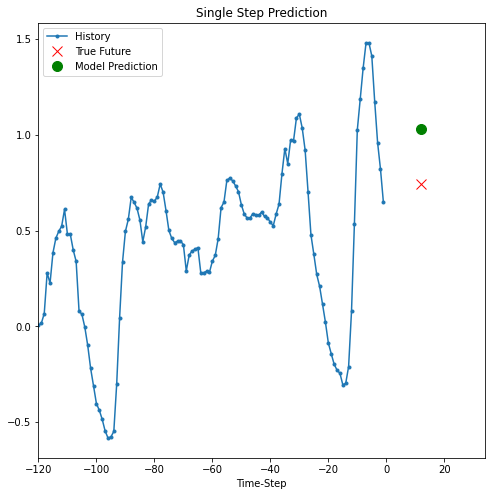

(120, 7)
(1,)


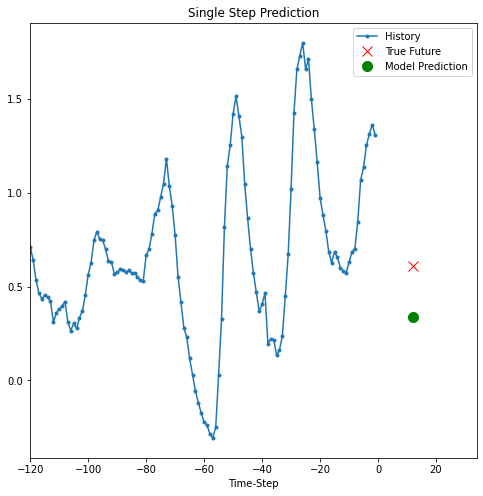

In [33]:
# Let us take 5 instances from the validation set, and do predictions on them
for x, y in dataset_val.take(5):
    print(x[0].shape)
    print(y[0].shape)
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )